```
title: "Cloning ping from Scratch"
date: 2021-07-25
```

The [`ping`](https://en.wikipedia.org/wiki/Ping_(networking_utility)) utility found on many systems is typically a simple tool to determine if 2 computers can see each other on a network. It's been around in some form or another for nearly 40 years and is dead simple to use: `ping <somewhere>`. Some [other tools](https://github.com/orf/gping) can gussy up the output a bit but the fundamentals are the same.

```
$ ping google.com
PING google.com (172.217.6.46) 56(84) bytes of data.
64 bytes from sfo03s08-in-f46.1e100.net (172.217.6.46): icmp_seq=1 ttl=116 time=5.47 ms
64 bytes from sfo03s08-in-f46.1e100.net (172.217.6.46): icmp_seq=2 ttl=116 time=5.63 ms
^C
--- google.com ping statistics ---
9 packets transmitted, 9 received, 0% packet loss, time 8015ms
rtt min/avg/max/mdev = 5.251/5.607/5.916/0.167 ms
```

Using `google.com` as the destination of course invokes a DNS lookup before `ping` can find the address (`172.217.6.46` in this case) to send the actual rquest to, so if that's a problem you can also use an IP directly: `ping 1.1.1.1`. In the output most fields are pretty straightforward, a successful response (i.e. one that hasn't timed out) indicates that the destination is reachable and gives a latency estimate (round trip, so the time to `google.com` and back). The `icmp_seq` indicates the sequence number, a (usually monotonically increasing) value set by the sender. `ttl` stands for [time to live](https://en.wikipedia.org/wiki/Time_to_live), which is the maximum of [network hops](https://en.wikipedia.org/wiki/Hop_(networking)) allowed by the request (fun fact: this is "supposed" to be a number of seconds but nearly everyone uses 1 hop == +1 TTL). Sounds great, let's implement it from scratch in Python (limited to IPv4 only for brevity).

`ping` doesn't use UDP or TCP to send data around, instead it uses [Internet Control Message Protocol](https://en.wikipedia.org/wiki/Internet_Control_Message_Protocol) or ICMP. Wikipedia has a [nice diagram](https://en.wikipedia.org/wiki/Ping_(networking_utility)#ICMP_packet). Ping sends an "echo request" (stealing more terms from radar world) to the destination and waits for an "echo reply." These are indicated by some constants in the ICMP header, defined in [RFC 792](https://datatracker.ietf.org/doc/html/rfc792).

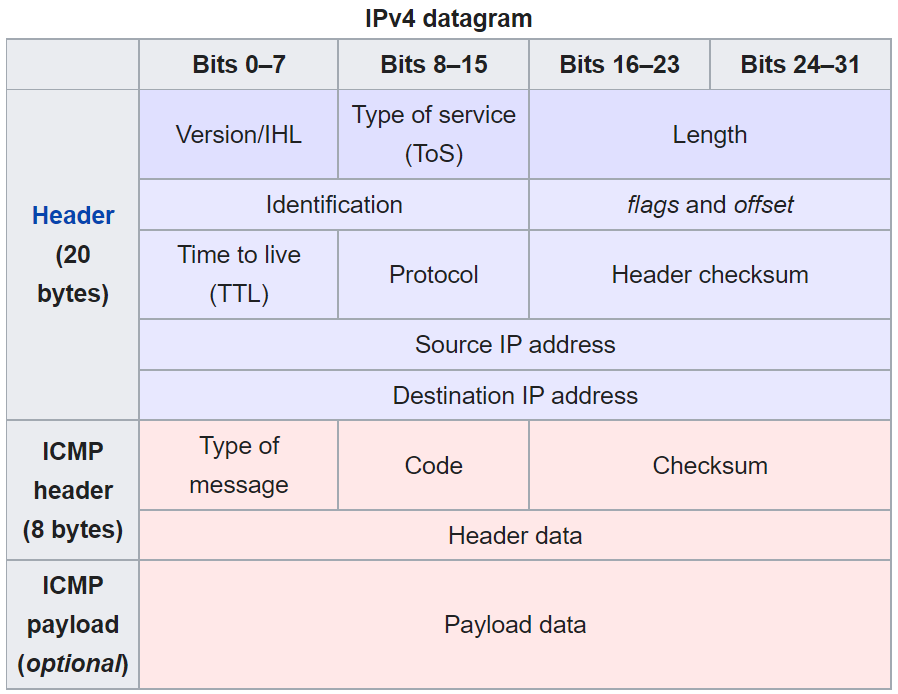

The astute reader will notice an [IPv4 header](https://en.wikipedia.org/wiki/IPv4#Header) followed by the actual ICMP data. Since we're not concerned with the details of the [IP networking layer](https://en.wikipedia.org/wiki/Network_layer) here, we can leave those details to Python and focus on implementing the ICMP packet (un)marshaling. Turns out that diagram isn't that nice though since it doesn't detail the "Header data" which is split into 2 bytes for an identifier (which will be returned by the sender in the reply) and the sequence number. First we'll need to implement the checksum algorithm to fill in the relevant slot above, then we can write a function to construct ICMP packets, and lastly we just need to send these over an IP socket and we'll be pinging!

The ICMP checksum is the [one's complement](https://en.wikipedia.org/wiki/Ones%27_complement) of the ICMP header and payload (not including the IPv4 header). 

In [4]:
import struct  # We'll need this to go between bytes <-> integers

def checksum(packet_bytes: bytes) -> int:
    # First, pad bytes so it's divisible by 2
    padding = [0] * (len(packet_bytes) % 2)
    packet_bytes = packet_bytes + bytes(padding)

    # Split bytes up into shorts
    parts = [packet_bytes[i : i + 2] for i in range(0, len(packet_bytes), 2)]

    # Unpack the 'bytes' into Python integers
    parts = [struct.unpack(">H", part)[0] for part in parts]

    # Add everything up and flip the bits (one's complement)
    checksum = sum(parts)
    checksum = ~checksum

    # Chop off any overflow, it doesn't affect the checksum
    checksum = checksum & 0xFFFF

    return checksum

To use this checksum we'll need to partially construct the packet with a blank spot for the checksum (we'll leave it as `0`), then add the checksum to the packet in-place. Here's how we can make an ICMP packet using the description above:

In [5]:
def create_icmp_packet(
    type: int,
    code: int,
    sequence_number: int,
    payload: bytes,
) -> bytes:
    # Header has these fields and sizes (in bytes):
    # type (1 byte), code (1 byte), checksum (2 bytes)
    # id (2 bytes), sequence number (2 bytes)
    # If you are like me and can never remember what the letters mean,
    # consult https://docs.python.org/3/library/struct.html#format-characters
    icmp_format = ">BBHHH"

    # Hardcode the id since we're not using it at all
    id = 0x1234

    # Leave the checksum empty for now and fill it in later
    packet_checksum = 0

    # Fill out the initial packet contents
    header = struct.pack(icmp_format, type, code, packet_checksum, id, sequence_number)

    # Calculate the checksum
    packet_checksum = checksum(header + payload)

    # Insert the checksum into the packet
    header = struct.pack(icmp_format, type, code, packet_checksum, id, sequence_number)

    return header + payload

This this function in hand we have everything we need to start sending pings around. Let's open a socket and give it a whirl.

In [6]:
import socket
import time  # This will let us track the round trip time (rtt)
from typing import Tuple

# Constants from https://en.wikipedia.org/wiki/Ping_(networking_utility)#Echo_request
ECHO_REQUEST_TYPE = 0x8
ECHO_REQUEST_CODE = 0x0


def ping(socket: socket.SocketType, destination: str, sequence_number: int) -> Tuple[float, int]:
    """
    Ping `destination` using socket `socket` and return a tuple of the (rtt, ttl)
    """
    # Make the bytes for the packet
    packet = create_icmp_packet(
        type=ECHO_REQUEST_TYPE, code=ECHO_REQUEST_CODE, sequence_number=sequence_number, payload=bytes()
    )

    # Run a round trip to the destination while tracking the execution time
    start = time.perf_counter_ns()

    # sendto() expects a port but doesn't use it for AF_INET (see usage below), so pass 1 to make it happy
    socket.sendto(packet, (destination, 1))
    
    # The response should be 28 bytes
    recv_bytes = socket.recv(28)

    # Caluclate the time that sendto() and recv() took
    end = time.perf_counter_ns()
    rtt_ms = (end - start) / 1000 / 1000

    # Unpack the IP header (the first 20 bytes of the response) so we can
    # extract the TTL from the response
    (
        version_and_length,
        services,
        total_length,
        id,
        flags,
        ttl,
        protocol,
        checksum,
        source,
        dest,
    ) = struct.unpack(">BBHHHBBHII", recv_bytes[:20])

    return rtt_ms, ttl, recv_bytes

In [8]:
ICMP_PROTOCOL = 0x1

# Use SOCK_RAW so we can fill in the details we need manually and bypass TCP
# See https://linux.die.net/man/7/raw for details
socket = socket.socket(socket.AF_INET, socket.SOCK_RAW, proto=ICMP_PROTOCOL)

PermissionError: [Errno 1] Operation not permitted

Uh oh! `ping` has a quirk where (on Linux), it [requires](https://unix.stackexchange.com/questions/382771/why-does-ping-need-setuid-permission) the setuid bit on its executable or to be run as a privileged user since it needs to create a raw socket (in my case I had to run `jupyter notebook` as root with the `--allow-root` flag).

In [7]:
ICMP_PROTOCOL = 0x1

my_socket = socket.socket(socket.AF_INET, socket.SOCK_RAW, proto=ICMP_PROTOCOL)
rtt_ms, ttl, recv_bytes = ping(socket=my_socket, destination="1.1.1.1", sequence_number=1)
print(f"{rtt_ms=}")
print(f"{ttl=}")
print(f"bytes={len(recv_bytes)}")

rtt_ms=5.3168429999999995
ttl=55
bytes=28


Some sweet numbers! Let's compare it to the built-in ping (on Ubuntu 18.04):

```
$ ping 1.1.1.1
PING 1.1.1.1 (1.1.1.1) 56(84) bytes of data.
64 bytes from 1.1.1.1: icmp_seq=1 ttl=55 time=5.63 ms
64 bytes from 1.1.1.1: icmp_seq=2 ttl=55 time=5.70 ms
```

The results from the Python implementation look close enough to me! A quick loop lets us ping as long as necessary.

In [8]:
destination = "1.1.1.1"

for i in range(4):
    rrt_ms, ttl, recv_bytes = ping(socket=my_socket, destination=destination, sequence_number=i)
    print(f"{len(recv_bytes)} bytes from {destination}: icmp_seq={i} ttl={ttl} time={round(rtt_ms, 2)} ms")
    time.sleep(1)

28 bytes from 1.1.1.1: icmp_seq=0 ttl=55 time=5.32 ms
28 bytes from 1.1.1.1: icmp_seq=1 ttl=55 time=5.32 ms
28 bytes from 1.1.1.1: icmp_seq=2 ttl=55 time=5.32 ms
28 bytes from 1.1.1.1: icmp_seq=3 ttl=55 time=5.32 ms


Here the responses are smaller than Ubuntu's ping since we're sending an empty payload, whereas Ubuntu's ping sends along an 8 byte timestamp and 48 bytes of ASCII characters (somewhat configurable through the `-p` option).

This simplified ping misses some of the extra functionality you'll find in a real implementation of `ping`, such as:
* Flood pings `ping -f ...`: sends a [flood of ICMP requests](https://en.wikipedia.org/wiki/Ping_flood) (as if we removed the `time.sleep(1)` in the loop above) in close succession. There are some legitmate use case for stress-testing your network.
* With [MTU (Maximum Transmission Unit) discovery](https://en.wikipedia.org/wiki/Path_MTU_Discovery), `ping` can figure out the MTU through all the hops between the source and destination. Sending a ping larger than the MTU can trigger a ["ping of death"](https://en.wikipedia.org/wiki/Ping_of_death).
* Ping supports broadcasting, but many hosts have it disabled (so they won't respond to broadcast pings, check on Linux with `sysctl net.ipv4.icmp_echo_ignore_broadcasts`) for security reasons (it makes it easy to create a ping flood).
* Ping has an adaptive mode (`ping -A`) where it will try to only have 1 in-flight ping at any time (the example here is implicitly adaptive since it waits on a blocking call to `recv` before sending another ping).